In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (309).jpg
/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (2320).jpg
/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (912).tif
/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (363).jpg
/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (624).tif
/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (475).tif
/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (696).jpg
/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (1869).jp


Image counts per category:

--- TRAIN ---
fire: 10800 images
non fire: 10800 images
Smoke: 10800 images

--- TEST ---
fire: 3500 images
non fire: 3500 images
Smoke: 3500 images


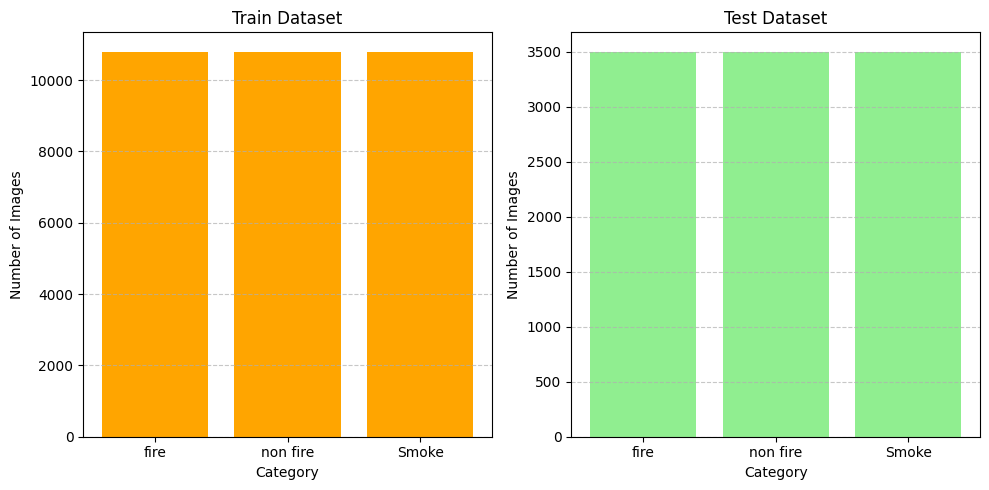

In [4]:
import os
import matplotlib.pyplot as plt

# Base directory of your dataset
base_dir = '/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET'

# Categories
categories = ['fire', 'non fire', 'Smoke']
splits = ['train', 'test']

# To store counts
data_counts = {'train': {}, 'test': {}}

# Count images in each category
for split in splits:
    for category in categories:
        path = os.path.join(base_dir, split, category)
        if os.path.exists(path):
            count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
        else:
            count = 0
        data_counts[split][category] = count

# Print counts
print("\nImage counts per category:")
for split in splits:
    print(f"\n--- {split.upper()} ---")
    for category, count in data_counts[split].items():
        print(f"{category}: {count} images")

# Plot histograms
plt.figure(figsize=(10,5))

# Train histogram
plt.subplot(1, 2, 1)
plt.bar(data_counts['train'].keys(), data_counts['train'].values(), color='orange')
plt.title('Train Dataset')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Test histogram
plt.subplot(1, 2, 2)
plt.bar(data_counts['test'].keys(), data_counts['test'].values(), color='lightgreen')
plt.title('Test Dataset')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [7]:
train_dir = "/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train"
test_dir="/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test"

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [10]:

full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)


In [26]:
class_names = full_train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['Smoke', 'fire', 'non fire']


In [11]:
# Print dataset sizes
print("Number of images in Train Dataset:", len(train_dataset))
print("Number of images in Validation Dataset:", len(val_dataset))
print("Number of images in Test Dataset:", len(test_dataset))


Number of images in Train Dataset: 25918
Number of images in Validation Dataset: 6480
Number of images in Test Dataset: 10500


In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


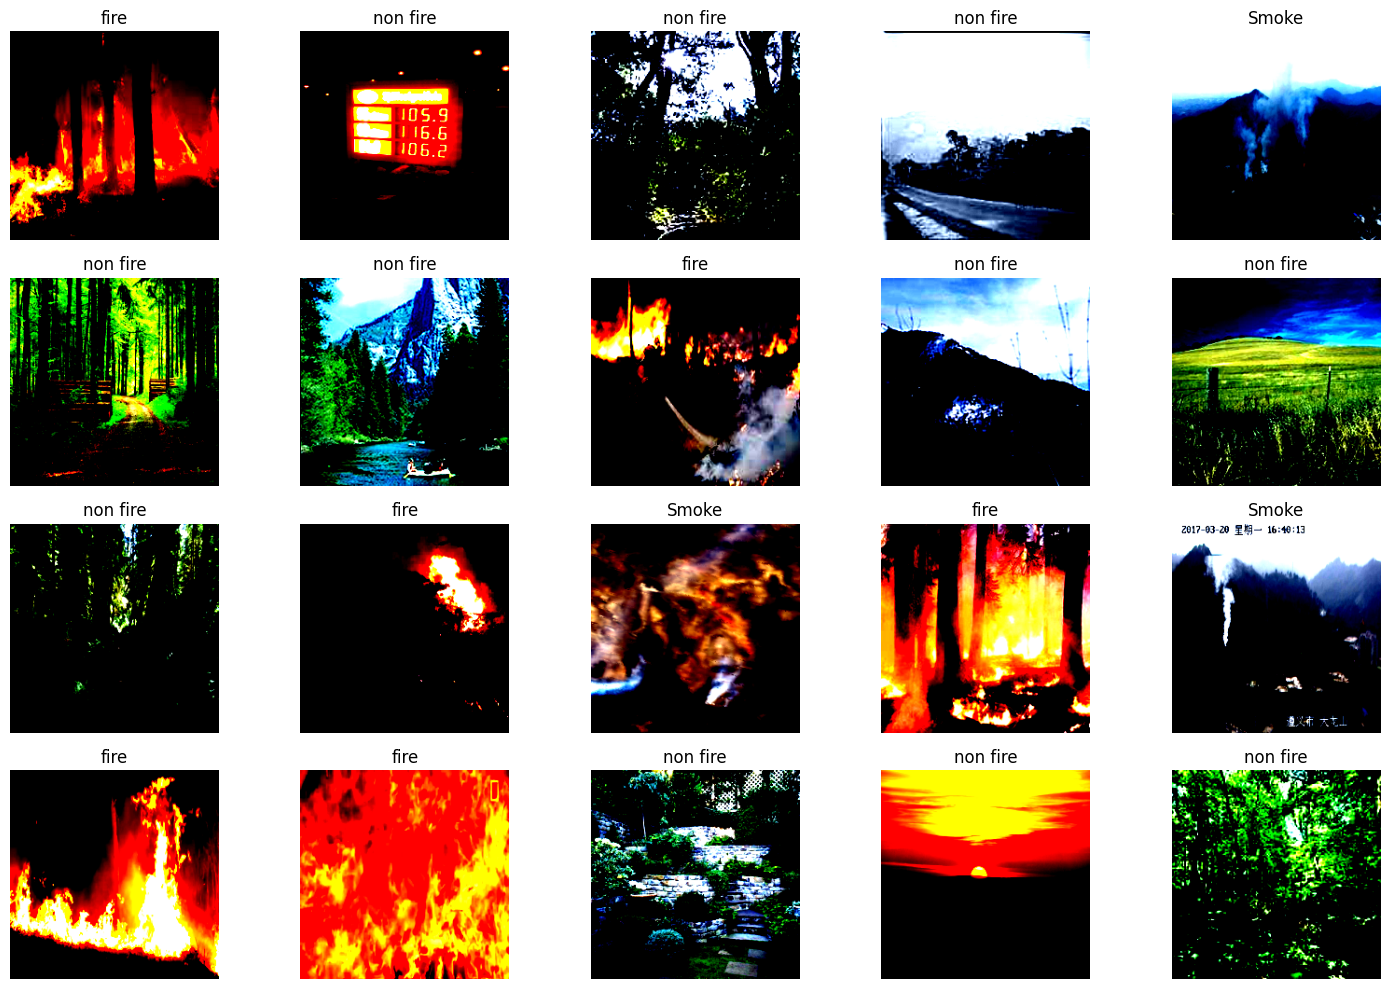

In [35]:
loader_to_show = train_loader   
images, labels = next(iter(loader_to_show))
class_names = full_train_dataset.classes

plt.figure(figsize=(15, 10))
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    img = images[i].permute(1, 2, 0).numpy()  
    img = np.clip(img, 0, 1)  
    
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
hidden_units=128
num_classes=3

In [14]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the head with custom layers
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, hidden_units),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(hidden_units, num_classes)
)
model = model.to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Trainable parameters: 131587


In [15]:
# Loss and Optimizer (Head Only)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.head.parameters(),lr=1e-3,weight_decay=1e-2)  



In [17]:
# Early Stopping Setup
patience = 3
best_val_loss = float('inf')
patience_counter = 0

In [18]:
import torch.nn.functional as F

def swin_forward(model, images):
    features = model.forward_features(images)           # [B, 7, 7, 1024]
    features = features.permute(0, 3, 1, 2)            # [B, 1024, 7, 7]
    features = F.adaptive_avg_pool2d(features, 1).flatten(1)  # [B, 1024]
    outputs = model.head(features)                      # [B, num_classes]
    return outputs

In [19]:
# Training with Early Stopping
num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = swin_forward(model, images) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()


    train_acc = 100. * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs=swin_forward(model,images)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()


    val_loss /= len(val_loader)
    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_swin_transformer.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

Epoch 1/5: 100%|██████████| 810/810 [05:07<00:00,  2.64it/s]



Epoch [1/5] Train Loss: 0.0680 | Train Acc: 97.96% | Val Loss: 0.0456 | Val Acc: 98.63%


Epoch 2/5: 100%|██████████| 810/810 [05:07<00:00,  2.63it/s]



Epoch [2/5] Train Loss: 0.0389 | Train Acc: 98.81% | Val Loss: 0.0399 | Val Acc: 98.64%


Epoch 3/5: 100%|██████████| 810/810 [05:07<00:00,  2.63it/s]



Epoch [3/5] Train Loss: 0.0368 | Train Acc: 98.77% | Val Loss: 0.0348 | Val Acc: 98.95%


Epoch 4/5: 100%|██████████| 810/810 [05:07<00:00,  2.63it/s]



Epoch [4/5] Train Loss: 0.0334 | Train Acc: 98.92% | Val Loss: 0.0383 | Val Acc: 98.78%


Epoch 5/5: 100%|██████████| 810/810 [05:08<00:00,  2.62it/s]



Epoch [5/5] Train Loss: 0.0293 | Train Acc: 98.99% | Val Loss: 0.0384 | Val Acc: 98.77%


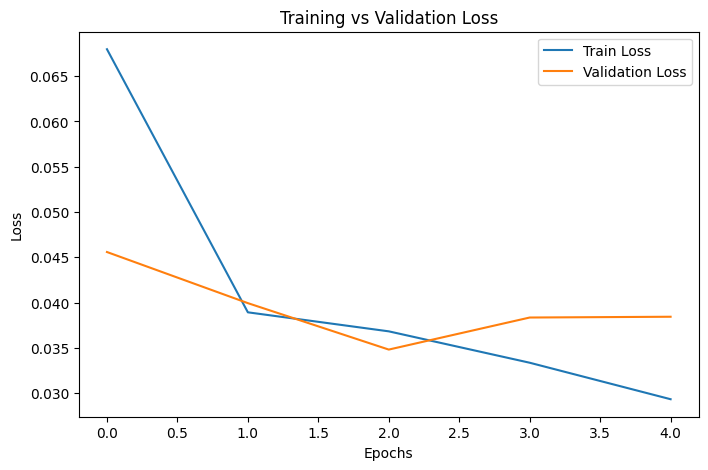

In [20]:
# Loss Curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [21]:
model.load_state_dict(torch.load("best_swin_transformer.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = swin_forward(model,images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = 100. * np.sum(all_preds == all_labels) / len(all_labels)
print(f"\nTest Accuracy: {test_acc:.2f}%")

Testing: 100%|██████████| 329/329 [02:15<00:00,  2.43it/s]


Test Accuracy: 99.20%



--- Classification Report ---
              precision    recall  f1-score   support

       Smoke       0.99      0.99      0.99      3500
        fire       0.99      0.99      0.99      3500
    non fire       1.00      1.00      1.00      3500

    accuracy                           0.99     10500
   macro avg       0.99      0.99      0.99     10500
weighted avg       0.99      0.99      0.99     10500



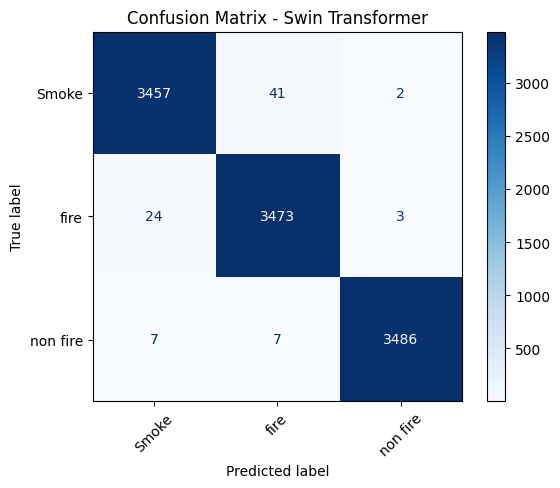

In [27]:
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Swin Transformer")
plt.show()

In [28]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last stage (Stage 4)
for param in model.layers[-1].parameters():
    param.requires_grad = True

# Replace classification head
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, hidden_units),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(hidden_units, num_classes)
)

model = model.to(device)

# Check trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 27436099


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),lr=1e-3,weight_decay=1e-2)

In [30]:
best_val_loss = float('inf')
patience = 3
patience_counter = 0

In [31]:
train_losses, val_losses = [], []
num_epochs=10
for epoch in range(num_epochs):
    # ------------------ TRAIN ------------------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        features = model.forward_features(images)              # [B, 7, 7, 1024]
        features = features.permute(0, 3, 1, 2)                # [B, 1024, 7, 7]
        features = F.adaptive_avg_pool2d(features, 1).flatten(1)  # [B, 1024]
        outputs = model.head(features)                         # [B, num_classes]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)

    # ------------------ VALIDATION ------------------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)

            features = model.forward_features(images)
            features = features.permute(0, 3, 1, 2)
            features = F.adaptive_avg_pool2d(features, 1).flatten(1)
            outputs = model.head(features)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # ------------------ EARLY STOPPING ------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_swin_transformer.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/10 - Validation: 100%|██████████| 203/203 [01:18<00:00,  2.59it/s]



Epoch [1/10]
Train Loss: 0.0866 | Train Acc: 97.55%
Val Loss: 0.0740 | Val Acc: 98.18%


Epoch 2/10 - Validation: 100%|██████████| 203/203 [01:17<00:00,  2.62it/s]



Epoch [2/10]
Train Loss: 0.0598 | Train Acc: 98.32%
Val Loss: 0.0468 | Val Acc: 98.64%


Epoch 3/10 - Validation: 100%|██████████| 203/203 [01:16<00:00,  2.66it/s]



Epoch [3/10]
Train Loss: 0.0528 | Train Acc: 98.50%
Val Loss: 0.0480 | Val Acc: 98.50%


Epoch 4/10 - Validation: 100%|██████████| 203/203 [01:16<00:00,  2.66it/s]



Epoch [4/10]
Train Loss: 0.0467 | Train Acc: 98.57%
Val Loss: 0.0558 | Val Acc: 98.58%


Epoch 5/10 - Validation: 100%|██████████| 203/203 [01:16<00:00,  2.67it/s]



Epoch [5/10]
Train Loss: 0.0471 | Train Acc: 98.59%
Val Loss: 0.0443 | Val Acc: 98.73%


Epoch 6/10 - Validation: 100%|██████████| 203/203 [01:16<00:00,  2.66it/s]



Epoch [6/10]
Train Loss: 0.0433 | Train Acc: 98.61%
Val Loss: 0.0355 | Val Acc: 98.77%


Epoch 7/10 - Validation: 100%|██████████| 203/203 [01:16<00:00,  2.66it/s]



Epoch [7/10]
Train Loss: 0.0416 | Train Acc: 98.70%
Val Loss: 0.0395 | Val Acc: 98.72%


Epoch 8/10 - Validation: 100%|██████████| 203/203 [01:16<00:00,  2.66it/s]



Epoch [8/10]
Train Loss: 0.0388 | Train Acc: 98.75%
Val Loss: 0.0467 | Val Acc: 98.73%


Epoch 9/10 - Validation: 100%|██████████| 203/203 [01:18<00:00,  2.59it/s]


Epoch [9/10]
Train Loss: 0.0377 | Train Acc: 98.81%
Val Loss: 0.0391 | Val Acc: 98.66%
Early stopping triggered!


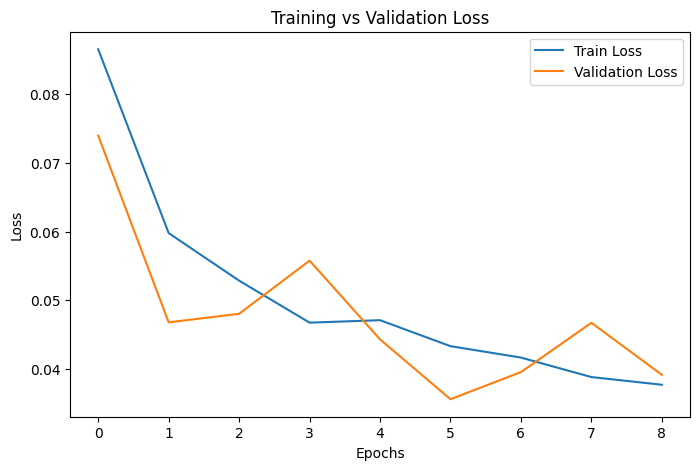

In [32]:
# Loss Curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [36]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        features = model.forward_features(images)
        features = features.permute(0, 3, 1, 2)
        features = F.adaptive_avg_pool2d(features, 1).flatten(1)
        outputs = model.head(features)

        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = 100. * np.sum(all_preds == all_labels) / len(all_labels)
print(f"\nTest Accuracy: {test_acc:.2f}%")

Testing: 100%|██████████| 329/329 [02:01<00:00,  2.70it/s]


Test Accuracy: 98.90%


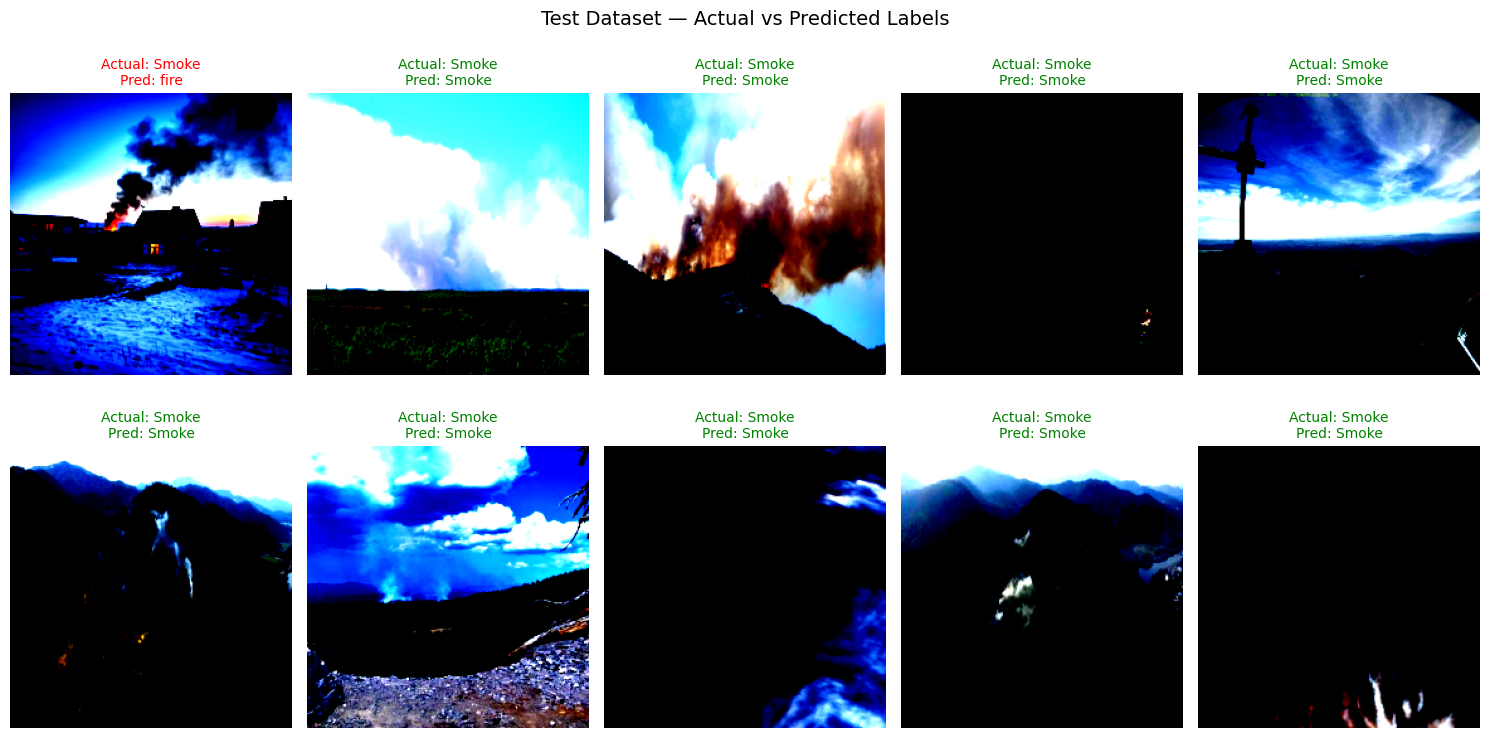

In [37]:
model.eval()
class_names = full_train_dataset.classes
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    features = model.forward_features(images)
    features = features.permute(0, 3, 1, 2)
    features = F.adaptive_avg_pool2d(features, 1).flatten(1)
    outputs = model.head(features)
    _, preds = outputs.max(1)

plt.figure(figsize=(15, 8))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    actual = class_names[labels[i].item()]
    predicted = class_names[preds[i].item()]
    
    plt.imshow(img)
    plt.title(f"Actual: {actual}\nPred: {predicted}",
              color=("green" if actual == predicted else "red"),
              fontsize=10)
    plt.axis("off")

plt.suptitle("Test Dataset — Actual vs Predicted Labels", fontsize=14)
plt.tight_layout()
plt.show()



--- Classification Report ---
              precision    recall  f1-score   support

       Smoke       0.99      0.97      0.98      2136
        fire       0.97      0.99      0.98      2145
    non fire       1.00      0.99      0.99      2199

    accuracy                           0.99      6480
   macro avg       0.99      0.99      0.99      6480
weighted avg       0.99      0.99      0.99      6480



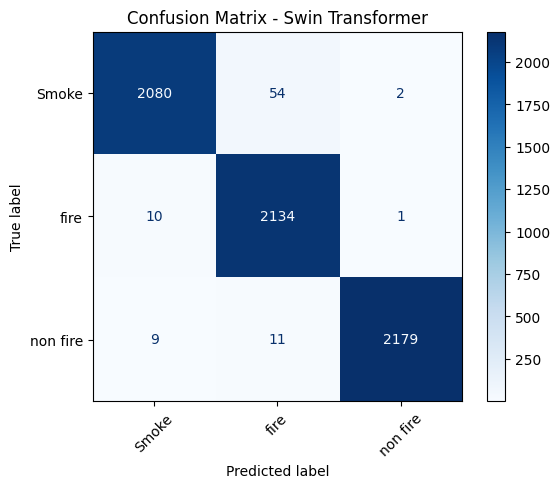

In [34]:
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Swin Transformer")
plt.show()